## Generating questions and answers for reaching definitions

In [1]:
import ast
import random

import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('../output_data/detailed_travel_routes.csv')

# Parse columns
df['Domain'] = df['Domain'].apply(lambda x: ast.literal_eval(x.replace('coordinates = ', '').strip()))
df['Plan'] = df['Plan'].apply(ast.literal_eval)
df['Detailed Plan'] = df['Detailed Plan'].apply(ast.literal_eval)

df

,id,Domain,Goal,Plan,Detailed Plan
0,0,"[[-71.22407723, 42.20650415], [-71.06341724278...",WESTWOOD/PEMBROKE HEALTH SYSTEM WESTWOOD (WEST...,"[[Drive north on Abbey Road., Turn left onto C...",[[{'instruction': 'Drive north on Abbey Road.'...
1,1,"[[-80.31080036, 26.01301541], [-80.21063654, 2...","MEMORIAL HOSPITAL WEST (PEMBROKE PINES, FL) to...","[[Drive northwest., Turn left after 19 meters ...","[[{'instruction': 'Drive northwest.', 'name': ..."
2,2,"[[-98.57619951, 29.52010675], [-97.7136084, 30...","CLARITY CHILD GUIDANCE CENTER (SAN ANTONIO, TX...","[[Drive east., Turn left onto Tom Slick., Turn...","[[{'instruction': 'Drive east.', 'name': '-', ..."
3,3,"[[-81.4371032715, 28.2898006439], [-80.3951633...","Kissimmee Gateway Airport (ORLANDO, FL) to IND...","[[Drive east on Patrick Street., Turn left ont...",[[{'instruction': 'Drive east on Patrick Stree...
4,4,"[[-122.2488937, 38.11790375], [-122.8130035, 3...",ST. HELENA HOSPITAL CENTER FOR BEHAVIORAL HEAL...,"[[Drive north on Broadway Street., Turn left o...",[[{'instruction': 'Drive north on Broadway Str...
...,...,...,...,...,...
495,495,"[[-90.709503, 42.402], [-92.40029907226562, 42...","Dubuque Regional Airport (DUBUQUE, IA) to Wate...","[[Drive north., Bear right after 1129 meters o...","[[{'instruction': 'Drive north.', 'name': '-',..."
496,496,"[[-76.56655563780009, 42.9295192], [-76.106300...","Seward, William H., House (Auburn, NY) to Syra...","[[Drive north., Turn left onto South Street/NY...","[[{'instruction': 'Drive north.', 'name': '-',..."
497,497,"[[-71.06823934295548, 42.35671345], [-72.2428,...","Headquarters House (Boston, MA) to BAYSTATE MA...","[[Drive west on Beacon Street., Bear left towa...",[[{'instruction': 'Drive west on Beacon Street...
498,498,"[[-86.58465712669839, 34.73047047522626], [-87...","Milligan Block (Huntsville, AL) to Northwest A...","[[Drive northwest on East Side Square., Take t...",[[{'instruction': 'Drive northwest on East Sid...


#### Find continuations

(Instances where the steps do not result in a road change)

In [2]:
def find_continuations(df):
    # Define the extra columns:
    columns = list(df.columns) + [
        'continuation_entry',    # Index in the route where we enter the street
        'continuation_exit',     # Index in the route where we exit the street
    ]

    new_df = pd.DataFrame(columns=columns)
    for _, row in df.iterrows():
        for route_idx, detailed_route in enumerate(row['Detailed Plan']):
            current_name = ''
            continuation_entry = 0
            for step_idx, step in enumerate(detailed_route):
                # Skip past all unnamed streets (too vague to ask about continuations)
                if current_name == '':
                    if step['name'] != '-':
                        continuation_entry = step_idx
                        current_name = step['name']
                    else:
                        continue
                
                # Continuing on the same street
                if step['name'] == current_name:
                    continue
                
                # Exiting the current street
                if step['name'] != current_name:
                    # Add this instance if there were multiple steps between this transition
                    if step_idx - continuation_entry > 1:
                        new_row = row.to_dict()
                        new_row.update({
                            'Plan': row['Plan'][route_idx],
                            'Detailed Plan': row['Detailed Plan'][route_idx],  
                            'continuation_entry': continuation_entry,
                            'continuation_exit':  step_idx,
                        })
                        new_df.loc[len(new_df)] = new_row
                    if step['name'] == '-':
                        current_name = ''
                    else:
                        # Update entry idx and current name
                        continuation_entry = step_idx
                        current_name = step['name']

    return new_df

df = find_continuations(df)

df

,id,Domain,Goal,Plan,Detailed Plan,continuation_entry,continuation_exit
0,0,"[[-71.22407723, 42.20650415], [-71.06341724278...",WESTWOOD/PEMBROKE HEALTH SYSTEM WESTWOOD (WEST...,"[Drive north on Abbey Road., Turn left onto Cl...","[{'instruction': 'Drive north on Abbey Road.',...",1,3
1,0,"[[-71.22407723, 42.20650415], [-71.06341724278...",WESTWOOD/PEMBROKE HEALTH SYSTEM WESTWOOD (WEST...,"[Drive north on Abbey Road., Turn left onto Cl...","[{'instruction': 'Drive north on Abbey Road.',...",13,15
2,0,"[[-71.22407723, 42.20650415], [-71.06341724278...",WESTWOOD/PEMBROKE HEALTH SYSTEM WESTWOOD (WEST...,"[Drive north on Abbey Road., Turn left onto Cl...","[{'instruction': 'Drive north on Abbey Road.',...",1,3
3,0,"[[-71.22407723, 42.20650415], [-71.06341724278...",WESTWOOD/PEMBROKE HEALTH SYSTEM WESTWOOD (WEST...,"[Drive north on Abbey Road., Turn left onto Cl...","[{'instruction': 'Drive north on Abbey Road.',...",10,12
4,0,"[[-71.22407723, 42.20650415], [-71.06341724278...",WESTWOOD/PEMBROKE HEALTH SYSTEM WESTWOOD (WEST...,"[Drive north on Abbey Road., Turn left onto Cl...","[{'instruction': 'Drive north on Abbey Road.',...",12,14
...,...,...,...,...,...,...,...
2531,499,"[[-73.126198, 41.163502], [-72.688066, 41.93851]]","Igor I Sikorsky Memorial Airport (BRIDGEPORT, ...","[Drive north on Great Meadow Road., Keep right...",[{'instruction': 'Drive north on Great Meadow ...,21,23
2532,499,"[[-73.126198, 41.163502], [-72.688066, 41.93851]]","Igor I Sikorsky Memorial Airport (BRIDGEPORT, ...","[Drive north on Great Meadow Road., Keep right...",[{'instruction': 'Drive north on Great Meadow ...,0,2
2533,499,"[[-73.126198, 41.163502], [-72.688066, 41.93851]]","Igor I Sikorsky Memorial Airport (BRIDGEPORT, ...","[Drive north on Great Meadow Road., Keep right...",[{'instruction': 'Drive north on Great Meadow ...,2,4
2534,499,"[[-73.126198, 41.163502], [-72.688066, 41.93851]]","Igor I Sikorsky Memorial Airport (BRIDGEPORT, ...","[Drive north on Great Meadow Road., Keep right...",[{'instruction': 'Drive north on Great Meadow ...,6,9


#### Check distribution of step counts

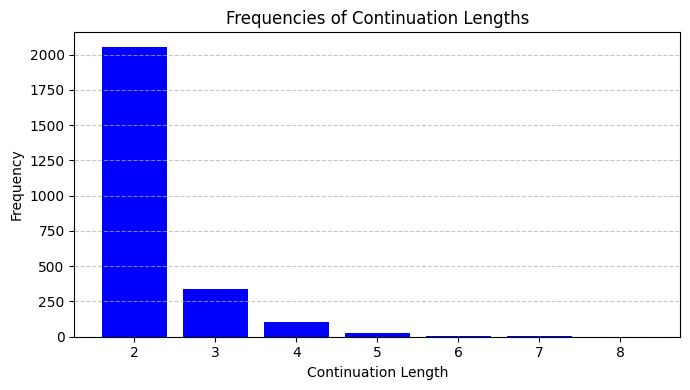

In [3]:
df['continuation_length'] = df['continuation_exit'] - df['continuation_entry']

freqs = df['continuation_length'].value_counts().sort_index()

plt.figure(figsize=(7, 4))
plt.bar(freqs.index, freqs.values, color='blue')
plt.xlabel('Continuation Length')
plt.ylabel('Frequency')
plt.title('Frequencies of Continuation Lengths')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Filter out duplicate segments


We need to make sure we are not including any data points that contain the same exact segment. To do this, we can extract the subarray that defines each continuation and drop duplicates.

In [4]:
# Returns the subarray of the plan that represents each series of continuations
def extract_subarray(row):
    start = row['continuation_entry']
    end = row['continuation_exit']
    return row['Plan'][start:end+1]

df['subarray'] = df.apply(extract_subarray, axis=1)

df = df.drop_duplicates(subset='subarray')

print(f'Number of rows with pattern: {df.shape[0]}')

df = df.drop(columns=['subarray'])

Number of rows with pattern: 2045


#### Add questions and answers

In [5]:
random.seed(42)

def add_start_and_end(row):
    # Create a range of random values for the two points to be chosen from
    # this is to create questions that are similar to the pattern that the model
    # is looking for, but slightly different

    offset = max((row['continuation_exit'] - row['continuation_entry'] + 1) // 2, 4)

    min_idx = max(0, row['continuation_entry'] - offset)
    max_idx = min(len(row['Plan']) - 2, row['continuation_exit'] + offset)

    step_1_idx = random.randint(min_idx, max_idx)
    step_2_idx = random.randint(min_idx, max_idx)

    # If the steps are the same, shift one of them
    if step_1_idx == step_2_idx:
        step_2_idx += 1

    # Return the steps in the correct order
    if step_1_idx < step_2_idx:
        return (step_1_idx, step_2_idx)
    else:
        return (step_2_idx, step_1_idx)


def add_ground_truth(row):
    if row['Detailed Plan'][row['start_idx']]['name'] == '-':
        return "No"
    elif row['Detailed Plan'][row['start_idx']]['name'] == row['Detailed Plan'][row['end_idx']]['name']:
        return "Yes"
    else:
        return "No"

def format_question(row):
    if row['start_idx'] >= row['continuation_entry']:
        street_name = row['Detailed Plan'][row['continuation_entry']]['name']
    else:
        street_name = row['Detailed Plan'][row['start_idx']]['name']
    # Edge case: no name, just reject row
    if street_name == "-":
        return None
    return f"After Step {row['end_idx']+1}, is the driver still on ‘{street_name}‘ from Step {row['start_idx']+1}?"

df[['start_idx','end_idx']] = df.apply(add_start_and_end, axis=1, result_type='expand')
df['Ground Truth'] = df.apply(add_ground_truth, axis=1)
df['Question'] = df.apply(format_question, axis=1)

#### Check results

In [6]:
percent_none = df['Question'].isna().mean() * 100
print(f"Percentage of Question = 'None': {percent_none:.2f}%")

df = df[df['Question'].notna()]

percent_yes = (df['Ground Truth'] == 'Yes').mean() * 100

print(f"Percentage of 'Yes': {percent_yes:.2f}%")

Percentage of Question = 'None': 9.78%
Percentage of 'Yes': 9.43%


#### Enforce 20% Yes ratio

In [7]:
yes_sample = df[df['Ground Truth'] == 'Yes'].sample(n=20, random_state=42)
no_sample = df[df['Ground Truth'] == 'No'].sample(n=80, random_state=42)

df = pd.concat([yes_sample, no_sample])

df = df.filter(items=[
    'id',
    'Goal',
    'Plan',
    'Question',
    'Ground Truth',
])

df = df.sort_values(by=['id'])
percent_yes = (df['Ground Truth'] == 'Yes').mean() * 100

print(f"Percentage of 'Yes': {percent_yes:.2f}%")

Percentage of 'Yes': 20.00%


#### Save data

In [8]:
df.to_csv('../output_data/data-flow_analyses/reaching_definitions.csv', index=False)

df

,id,Goal,Plan,Question,Ground Truth
31,6,"Aborn, John, House (Cambridge, MA) to Smith Ho...","[Drive southeast on Orchard Street., Turn righ...","After Step 11, is the driver still on ‘Mystic ...",No
37,6,"Aborn, John, House (Cambridge, MA) to Smith Ho...","[Drive southeast on Orchard Street., Turn left...","After Step 27, is the driver still on ‘Pond St...",No
38,6,"Aborn, John, House (Cambridge, MA) to Smith Ho...","[Drive southeast on Orchard Street., Turn left...","After Step 48, is the driver still on ‘Northga...",No
60,12,"Independence Junior High School (Independence,...","[Drive south on North 9th Street., Turn right ...","After Step 8, is the driver still on ‘US 75‘ f...",No
85,17,"Dunbar Hospital (Detroit, MI) to HILLSDALE COM...","[Drive southwest on Frederick Street., Turn ri...","After Step 10, is the driver still on ‘M 99‘ f...",No
...,...,...,...,...,...
2350,465,"Cape Cod Gateway Airport (HYANNIS, MA) to ARBO...","[Drive north., Turn right onto Mary Dunn Road....","After Step 11, is the driver still on ‘MA 28‘ ...",No
2412,479,"NORTHERN DUTCHESS HOSPITAL (RHINEBECK, NY) to ...","[Drive north., Turn left after 53 meters or 11...","After Step 40, is the driver still on ‘Bruckne...",No
2436,484,"GREENWICH HOSPITAL ASSOCIATION (GREENWICH, CT)...","[Drive south., Turn left onto Lake Avenue., Tu...","After Step 10, is the driver still on ‘Glenbro...",No
2470,487,"MARCUM AND WALLACE MEMORIAL HOSPITAL (IRVINE, ...","[Drive southwest on Mercy Court., Turn left on...","After Step 15, is the driver still on ‘US 150‘...",No
